<a href="https://colab.research.google.com/github/Akikan12/Public_Pro/blob/branch_A/sky_final_16bit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


def extract_light_source_region(image):

    # 画像をグレースケールに変換する
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 画像を二値化する
    _, binary_image = cv2.threshold(gray_image, 20, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    cv2_imshow(binary_image)

    # 輪郭を検出する
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #第二:一番外側の輪郭のみ抽出する,第三:水平・垂直・斜めの成分を圧縮して端点として格納

    rinkaku_list = []
    for i, cnt in enumerate(contours):
        # 輪郭の面積を計算する。
        area = cv2.contourArea(cnt)
        rinkaku_list.append(area)
        print(f"contour: {i}, area: {area}")

    max_rinkaku = max(rinkaku_list)

    # 最大面積を持つ輪郭を見つける
    max_contour = max(contours, key=cv2.contourArea) #contourArea:countoursの輪郭の面積を抽出する

    return max_contour,max_rinkaku

def calculate_mean_brightness(image,max_rinkaku):
    # 画像の高さと幅を取得
    height, width = image.shape[:2]

    # 画像の全画素の明るさを合計する変数を初期化
    total_brightness = 0

    # 画像の各画素についてループ処理
    for y in range(height):
        for x in range(width):
            # 各画素の明るさを取得して合計に加える
            pixel_brightness = sum(image[y, x]) / 3  # RGB各チャンネルの値を合計して平均を取る
            total_brightness += pixel_brightness
    print("総輝度数:{}".format(total_brightness))
    print("幅:{},高さ:{}".format(x,y))
    print("最大面積:{}".format(int(max_rinkaku)))

    # 全画素の明るさの合計を背景画素数(全体画素数-輪郭面積)で割って背景平均明るさを計算
    mean_brightness = total_brightness / (height * width - int(max_rinkaku))

    return mean_brightness


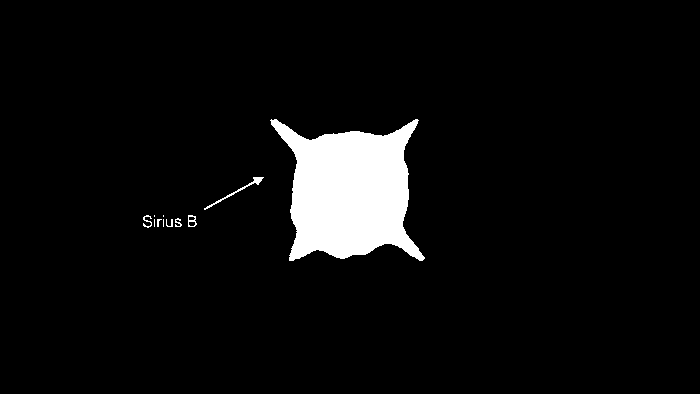

contour: 0, area: 9.0
contour: 1, area: 0.0
contour: 2, area: 9.0
contour: 3, area: 0.0
contour: 4, area: 13.0
contour: 5, area: 75.0
contour: 6, area: 0.0
contour: 7, area: 0.0
contour: 8, area: 19.0
contour: 9, area: 108.5
contour: 10, area: 13872.5


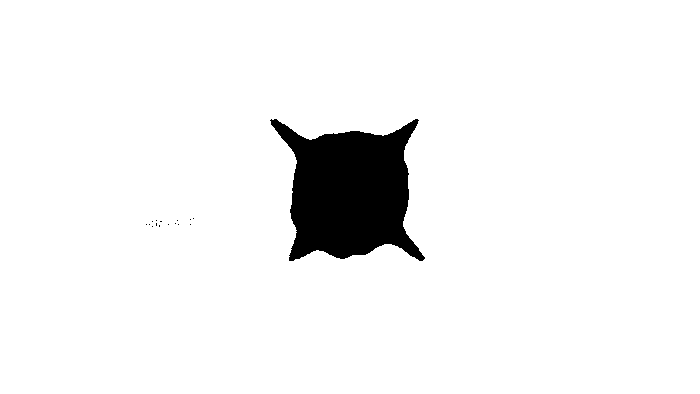

総輝度数:1571654400.0
幅:699,高さ:393
最大面積:13872
平均輝度:6000.329861641367


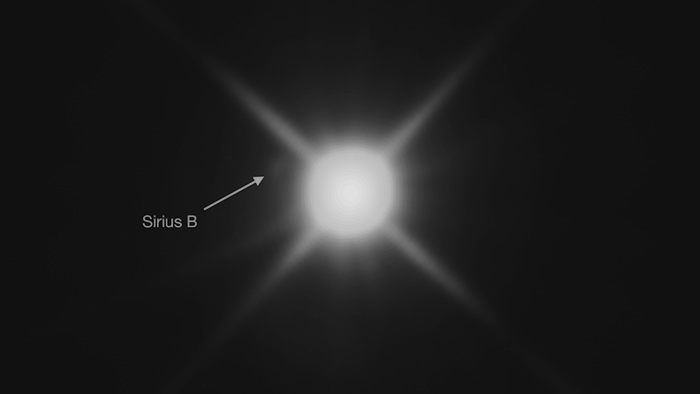

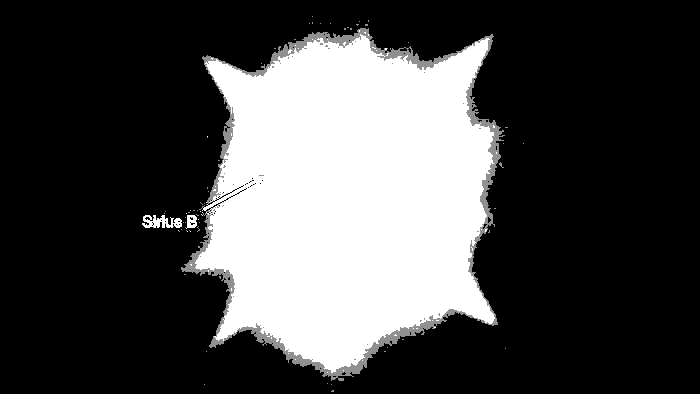

In [ ]:
# 画像の読み込みなどの前提条件
image_path = "/content/drive/MyDrive/画像処理/flated_image.pgm"
image = cv2.imread(image_path)
image_cp = image.copy() #マスク処理などの画像処理用

# 関数呼び出し
max_contour, max_rinkaku = extract_light_source_region(image)

# imageと同じサイズの白色マスク画像を作成する
size =image_cp.shape
black_img=np.zeros(size,np.uint8)
mask = black_img+255
cv2.drawContours(mask, [max_contour], 0, (0, 0, 0), -1)

# マスク合成.光源でない部分を抽出する。
img_AND = cv2.bitwise_and(image_cp, mask)

#画像を配列に変換
img_array = np.array(img_AND)

#16bitに拡張
img_array_16 = img_array.astype(np.uint16)*256  #65536/256=256

# 結果の表示や処理を行う
cv2.imwrite("/content/drive/MyDrive/画像処理/tentai_16_trim.ppm",img_array_16)
cv2_imshow(img_array_16)

cv2.waitKey(0)
cv2.destroyAllWindows()

# 関数呼び出し
mean_brightness = calculate_mean_brightness(img_array_16, max_rinkaku)


print("平均輝度:{}".format(mean_brightness))

#スカイ引き
#オリジナル画像を配列に変換
src_array = np.array(image)

#16bitに拡張
src_array_16 = src_array.astype(np.uint16)*256

sky_out = src_array_16 - int(mean_brightness)
sky_out = np.where(sky_out >= 60000, 0, sky_out) #輝度が60000以上のとき、その輝度を0とする

#スカイ引き後の画像を保存
cv2.imwrite("/content/drive/MyDrive/画像処理/sky_out.ppm",sky_out)

cv2_imshow(image)
cv2_imshow(sky_out)
cv2.waitKey(0)
cv2.destroyAllWindows()



黒マスク部分の輝度は０であるから、面積だけを計算し差分する。